<a href="https://colab.research.google.com/github/wilburshi/LogisticRegression_tutorial/blob/main/LogisticRegression_JuiceBundle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression for Juice Bundle Task

Logistic regression can analyze the choice pattern of the juice bundle task. In this tutorial, we examine a task in which juice A and B are in one bundle, and juice C and D are in another one.

Juice Bundle Task (Padoa-Schioppa, 2022)


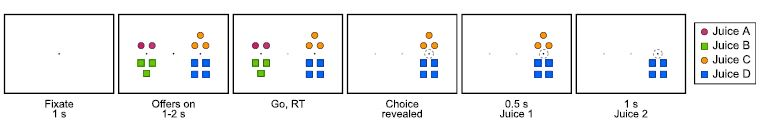

In [ ]:
from IPython.display import Image, display
print('Juice Bundle Task (Padoa-Schioppa, 2022)')
!git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
display(Image('LogisticRegression_tutorial/pics/bundle_tasks.jpg', width=400, unconfined=True)) # use it only for google colab 
# display(Image('../pics/bundle_tasks.jpg', width=800, unconfined=True))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import loadmat

## Simple regression

### Step 1: load data

First, let's load example data file named as `goodTrials_JB.mat`. It only contains trials that monkey has successfully chosen one of the juice option.  

`goodTrials_JB.mat` is a $N \times 6$, where $N$ is the number of the trials in this session, and in this example, $N =660$. The columns of this matrix indicated:

 - *column 1*: the trial number.

 - *column 2*: the quantity of juice A. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 3*: the quantity of juice B. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 4*: the quantity of juice C. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 5*: the quantity of juice D. The negative sign indicated that the stimulus/target is on the left side of the screen.
 
 - *column 6*: the chosen juice type, with 1 indicating AB and 2 indicating CD.


In [ ]:
# !git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
data = loadmat('LogisticRegression_tutorial/data/goodtrials_JB.mat')['goodTrials_JB'] # use it only for goole colab
# data = loadmat('../data/goodtrials_JB.mat')['goodTrials_JB'] # loadmat is a function in scipy.io used to load Matlab data file

# Independent variables
triNum = np.abs(data[:,0]) # trial number
QA = np.abs(data[:,1]) # quantity of juice A
QB = np.abs(data[:,2]) # quantity of juice B
QC = np.abs(data[:,3]) # quantity of juice A
QD = np.abs(data[:,4]) # quantity of juice B
SideAB = np.sign(data[:,1]) # side of target AB bundle. -1: left, 1: right, 0 forced choice

# Dependent variables
CJ = data[:,5]-1 # the type of chosen juice. 0: chosen A, 1: chosen B

ind_forced = (data[:,1] == 0) | (data[:,2] == 0) | (data[:,3] == 0) | (data[:,4] == 0) # index of forced choice
ind_nonforced = ~ind_forced

### Step 2: probit regression fitting
we use probit regression to fit the choice pattern. the model is as follows:

$ choice B = \Phi(X) $

$ X = a_1 q_A + a_2 q_B + a_3 q_C + a_4 q_D $

where $choice B = 1$ if juice B is chosen and 0 otherwise. $\Phi$ is the cumulative function of a Gaussian distribution (probit link). $q_J$ is the juice quantity for J in each trial. Here we defined $a_1 = -\eta\rho_A$, $a_2 = -\eta\rho_B$, $a_3 = \eta\rho_C$, and $a_4 = \eta$. The relative values $\rho_A$, $\rho_B$ and $\rho_C$ and the inverse temperature $\eta$ can thus be computed after the logistic regression from the fitted parameters.

In [ ]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit

In [ ]:
# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X1 = QA[ind_nonforced] 
X2 = QB[ind_nonforced] 
X3 = QC[ind_nonforced] 
X4 = QD[ind_nonforced] 

# probit regression
model = Probit(Y, np.transpose([X1, X2, X3, X4]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.276868
         Iterations 7


### Step 3: plotting
We plot the choice patterns as percentage of choice B v.s. value of AB bundle and value of CD bundle.

In [ ]:
eta = betas[3]
print('steepness η is: ', np.array2string(eta))
rho_D = np.array(1)
print('relative value ρ of D is: ', np.array2string(rho_D))
rho_C = betas[2]/betas[3]
print('relative value ρ of C is: ', np.array2string(rho_C))
rho_B = -betas[1]/betas[3]
print('relative value ρ of B is: ', np.array2string(rho_B))
rho_A = -betas[0]/betas[3]
print('relative value ρ of A is: ', np.array2string(rho_A))


steepness η is:  0.30566708
relative value ρ of D is:  1
relative value ρ of C is:  3.17908141
relative value ρ of B is:  0.73445341
relative value ρ of A is:  5.20334385


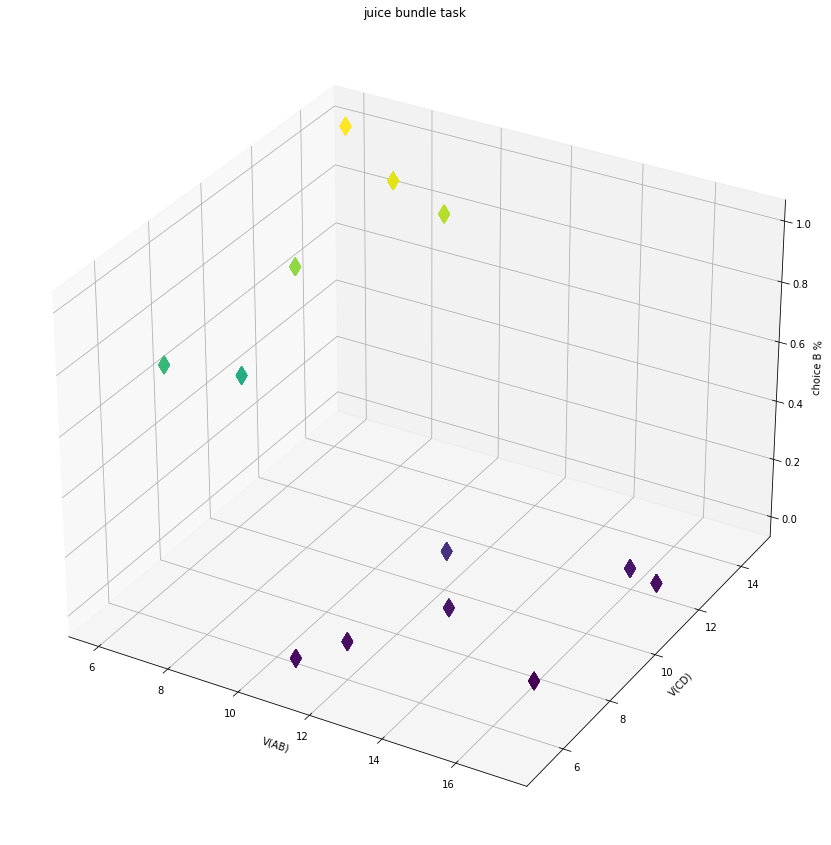

In [ ]:
# plot sigmoidal surface
X1_plot = X1
X2_plot = X2
X3_plot = X3
X4_plot = X4
VAB_plot = X1_plot*rho_A + X2_plot*rho_B
VCD_plot = X3_plot*rho_C + X4_plot*rho_D
Y_plot = probit_model.predict(np.transpose([ X1_plot, X2_plot, X3_plot, X4_plot]))

# plot
fig = plt.figure(figsize =(20, 15))
ax = plt.axes(projection ='3d')
ax.scatter3D(VAB_plot, VCD_plot, Y_plot, c=Y_plot, alpha=1, marker='d', s=150)
ax.set_xlabel('V(AB)')
ax.set_ylabel('V(CD)')
ax.set_zlabel('choice B %')
ax.set_title('juice bundle task');